# CONFLUENCE Tutorial: Distributed Basin Workflow with Delineation

This notebook demonstrates the distributed modeling approach using the delineation method. We'll use the same Bow River at Banff location but create a distributed model with multiple GRUs (Grouped Response Units).

## Key Differences from Lumped Model

- **Domain Method**: `delineate` instead of `lumped`
- **Stream Threshold**: 5000 (creates more sub-basins)
- **Multiple GRUs**: Each sub-basin becomes a GRU
- **Routing**: mizuRoute connects the GRUs
- **Spatial Mode**: Distributed instead of Lumped

## Learning Objectives

1. Understand watershed delineation with stream networks
2. Create a distributed model with multiple GRUs
3. Compare with lumped approach from Tutorial 1
4. Learn how to reuse data across experiments

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import contextily as cx
import xarray as xr
from IPython.display import Image, display

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. We'll modify the configuration from Tutorial 1 to create a distributed model.

In [2]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Verify paths exist
if not CONFLUENCE_CODE_DIR.exists():
    raise FileNotFoundError(f"CONFLUENCE code directory not found: {CONFLUENCE_CODE_DIR}")

if not CONFLUENCE_DATA_DIR.exists():
    print(f"Data directory doesn't exist. Creating: {CONFLUENCE_DATA_DIR}")
    CONFLUENCE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Load template configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

# Update core paths
config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Modify for distributed delineation
config_dict['DOMAIN_NAME'] = 'Bow_at_Banff_distributed'
config_dict['EXPERIMENT_ID'] = 'distributed_tutorial'
config_dict['DOMAIN_DEFINITION_METHOD'] = 'delineate'  # Changed from 'lumped'
config_dict['STREAM_THRESHOLD'] = 5000  # Higher threshold for fewer sub-basins
config_dict['DOMAIN_DISCRETIZATION'] = 'GRUs'  # Keep as GRUs
config_dict['SPATIAL_MODE'] = 'Distributed'  # Changed from 'Lumped'

# Use just one parallel process for this tutorial
config_dict['MPI_PROCESSES'] = 1

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_distributed.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Domain Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {confluence.config['STREAM_THRESHOLD']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

20:03:14 - INFO - ============================================================


2025-05-11 20:03:14,897 - confluence_general - INFO - ============================================================


20:03:14 - INFO - CONFLUENCE Logging Initialized


2025-05-11 20:03:14,898 - confluence_general - INFO - CONFLUENCE Logging Initialized


20:03:14 - INFO - Domain: Bow_at_Banff_distributed


2025-05-11 20:03:14,900 - confluence_general - INFO - Domain: Bow_at_Banff_distributed


20:03:14 - INFO - Experiment ID: distributed_tutorial


2025-05-11 20:03:14,902 - confluence_general - INFO - Experiment ID: distributed_tutorial


20:03:14 - INFO - Log Level: INFO


2025-05-11 20:03:14,904 - confluence_general - INFO - Log Level: INFO


20:03:14 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250511_200314.log


2025-05-11 20:03:14,905 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/confluence_general_Bow_at_Banff_distributed_20250511_200314.log


20:03:14 - INFO - ============================================================


2025-05-11 20:03:14,907 - confluence_general - INFO - ============================================================


20:03:14 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250511_200314.yaml


2025-05-11 20:03:14,929 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/_workLog_Bow_at_Banff_distributed/config_Bow_at_Banff_distributed_20250511_200314.yaml


20:03:14 - INFO - Initializing CONFLUENCE system


2025-05-11 20:03:14,931 - confluence_general - INFO - Initializing CONFLUENCE system


20:03:14 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


2025-05-11 20:03:14,933 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_distributed.yaml


20:03:14 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-11 20:03:14,935 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


20:03:15 - INFO - CONFLUENCE system initialized successfully


2025-05-11 20:03:15,269 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_distributed
Pour Point: 51.1722/-115.5717
Domain Method: delineate
Stream Threshold: 5000
Spatial Mode: Distributed
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2018-12-31 23:00


## 3. Project Setup - Organizing the Modeling Workflow

First, we'll establish a well-organized project structure, similar to what we did in Tutorial 1.

In [3]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

print("\nNote: The pour point location is identical to the lumped model.")
print("The difference is in how we subdivide the watershed above this point.")

=== Step 1: Project Initialization ===
20:03:15 - INFO - Setting up project for domain: Bow_at_Banff_distributed


2025-05-11 20:03:15,278 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_distributed


20:03:15 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed


2025-05-11 20:03:15,299 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed
2025-05-11 20:03:15,376 - pyogrio._io - INFO - Created 1 records


20:03:15 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp


2025-05-11 20:03:15,379 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_distributed
  📁 attributes
  📁 documentation
  📁 observations
  📁 optimisation
  📁 shapefiles

Note: The pour point location is identical to the lumped model.
The difference is in how we subdivide the watershed above this point.


## 4. Geospatial Domain Definition - Data Acquisition and Preparation

We'll reuse some of the geospatial data from the lumped model tutorial, where appropriate.

In [4]:
# Check if we can reuse data from the lumped model
lumped_dem_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'attributes' / 'elevation' / 'dem'
lumped_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'forcing' / 'raw_data'
can_reuse = lumped_dem_path.exists()
can_reuse_forcing = lumped_forcing_path.exists()

if can_reuse or can_reuse_forcing:
    import shutil
    
    # Create a function to copy files with name substitution
    def copy_with_name_substitution(src_path, dst_path, old_str='_lumped', new_str='_distributed'):
        if not src_path.exists():
            return False
            
        # Create destination directory if it doesn't exist
        dst_path.parent.mkdir(parents=True, exist_ok=True)
        
        if src_path.is_dir():
            # Copy entire directory
            if not dst_path.exists():
                dst_path.mkdir(parents=True, exist_ok=True)
                
            # Copy all files with name substitution
            for src_file in src_path.glob('**/*'):
                if src_file.is_file():
                    # Create relative path
                    rel_path = src_file.relative_to(src_path)
                    # Create new filename with substitution
                    new_name = src_file.name.replace(old_str, new_str)
                    # Create destination path
                    dst_file = dst_path / rel_path.parent / new_name
                    # Create parent directories if they don't exist
                    dst_file.parent.mkdir(parents=True, exist_ok=True)
                    # Copy the file
                    shutil.copy2(src_file, dst_file)
            return True
        elif src_path.is_file():
            # Copy single file with name substitution
            new_name = dst_path.name.replace(old_str, new_str)
            dst_file = dst_path.parent / new_name
            dst_file.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src_path, dst_file)
            return True
        
        return False

    print("Found existing geospatial data from lumped model. Copying and renaming files...")
    
    # Copy and rename DEM and other attribute data
    if can_reuse:
        # Define paths
        src_attr_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'attributes'
        dst_attr_path = project_dir / 'attributes'
        
        # Copy attributes with name substitution
        copied = copy_with_name_substitution(src_attr_path, dst_attr_path, '_lumped', '_distributed')
        if copied:
            print("✓ Copied and renamed attribute files from lumped model")
    
    # Copy and rename forcing data
    if can_reuse_forcing:
        # Define paths
        src_forcing_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'forcing' / 'raw_data'
        dst_forcing_path = project_dir / 'forcing' / 'raw_data'
        
        # Copy forcing data with name substitution
        copied = copy_with_name_substitution(src_forcing_path, dst_forcing_path, '_lumped', '_distributed')
        if copied:
            print("✓ Copied and renamed forcing data from lumped model")
            
    print("The distributed model will use these copied files as a starting point.")
else:
    print("No existing data found from the lumped model. Will acquire all data from scratch.")

    # Step 2: Geospatial Domain Definition - Data Acquisition
    print("\n=== Step 2: Geospatial Domain Definition - Data Acquisition ===")
    
    # Acquire attributes
    print("Acquiring geospatial attributes (DEM, soil, land cover)...")
    confluence.managers['data'].acquire_attributes()

    # Acquire forcings
    print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
    confluence.managers['data'].acquire_forcings()
    
print("\n✓ Geospatial attributes acquired")

Found existing geospatial data from lumped model. Copying and renaming files...
✓ Copied and renamed attribute files from lumped model
✓ Copied and renamed forcing data from lumped model
The distributed model will use these copied files as a starting point.

✓ Geospatial attributes acquired


## 6. Geospatial Domain Definition - Delineation with Stream Network

This is where the main difference occurs - we'll create multiple sub-basins connected by a stream network.

In [5]:
# Step 3: Geospatial Domain Definition - Delineation
print("=== Step 3: Geospatial Domain Definition - Delineation ===")

# Define domain
print(f"Delineating distributed watershed...")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream threshold: {confluence.config['STREAM_THRESHOLD']}")
print("\nThis will create multiple sub-basins connected by a stream network.")

watershed_path = confluence.managers['domain'].define_domain()

# Check outputs
basin_path = project_dir / 'shapefiles' / 'river_basins'
network_path = project_dir / 'shapefiles' / 'river_network'

if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    print(f"\n✓ Created basin shapefiles: {len(basin_files)}")
    
if network_path.exists():
    network_files = list(network_path.glob('*.shp'))
    print(f"✓ Created river network shapefiles: {len(network_files)}")
    
    # Load and check number of basins
    if basin_files:
        gdf = gpd.read_file(basin_files[0])
        print(f"\nNumber of sub-basins (GRUs): {len(gdf)}")
        print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")

=== Step 3: Geospatial Domain Definition - Delineation ===
Delineating distributed watershed...
Method: delineate
Stream threshold: 5000

This will create multiple sub-basins connected by a stream network.
20:03:23 - INFO - Domain definition workflow starting with: delineate


2025-05-11 20:03:23,643 - confluence_general - INFO - Domain definition workflow starting with: delineate


20:03:23 - INFO - Starting geofabric delineation


2025-05-11 20:03:23,646 - confluence_general - INFO - Starting geofabric delineation


20:03:23 - INFO - Geofabric delineation completed successfully


2025-05-11 20:03:23,649 - confluence_general - INFO - Geofabric delineation completed successfully


20:03:23 - INFO - Starting geofabric delineation for Bow_at_Banff_distributed


2025-05-11 20:03:23,651 - confluence_general - INFO - Starting geofabric delineation for Bow_at_Banff_distributed


20:03:23 - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8


2025-05-11 20:03:23,660 - confluence_general - INFO - Created interim directory: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8


20:03:23 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -v


2025-05-11 20:03:23,663 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -v


20:03:24 - INFO - Command output: On input demfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif
On input newfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif
Not Using mask file: N/A
PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000
Header read
Process: 0, totalX: 1260, totalY: 972
Process: 0, nx: 1260, ny: 972
Process: 0, xstart: 0, ystart: 0
Data read
Midpoint of partition: 0, nxm: 630, nym: 486, value: 2002.900024
Planchon grid initialized rank: 0
Rank: 0, Stack size: 102
Rank: 0, Stack size: 100102
Rank: 0, Stack size: 200102
Rank: 0, Stack size: 30

2025-05-11 20:03:24,770 - confluence_general - INFO - Command output: On input demfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif
On input newfile: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif
Not Using mask file: N/A
PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000
Header read
Process: 0, totalX: 1260, totalY: 972
Process: 0, nx: 1260, ny: 972
Process: 0, xstart: 0, ystart: 0
Data read
Midpoint of partition: 0, nxm: 630, nym: 486, value: 2002.900024
Planchon grid initialized rank: 0
Rank: 0, Stack size: 102
Rank: 0, Stack size: 100102
Rank: 0, Stack 

20:03:24 - INFO - Completed TauDEM step


2025-05-11 20:03:24,772 - confluence_general - INFO - Completed TauDEM step


20:03:24 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-sd8.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif


2025-05-11 20:03:24,774 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-sd8.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif


20:03:26 - INFO - Command output: D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Processors: 1
Header read time: 0.025659
Data read time: 0.041297
Compute Slope time: 0.290420
Write Slope time: 0.131969
Resolve Flat time: 0.712566
Write Flat time: 0.046450
Total time: 1.248363



2025-05-11 20:03:26,498 - confluence_general - INFO - Command output: D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000
Processors: 1
Header read time: 0.025659
Data read time: 0.041297
Compute Slope time: 0.290420
Write Slope time: 0.131969
Resolve Flat time: 0.712566
Write Flat time: 0.046450
Total time: 1.248363



20:03:26 - INFO - Completed TauDEM step


2025-05-11 20:03:26,500 - confluence_general - INFO - Completed TauDEM step


20:03:26 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -nc


2025-05-11 20:03:26,502 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -nc


20:03:27 - INFO - Command output: AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Number of Processes: 1
Read time: 0.034064
Compute time: 0.333427
Write time: 0.070069
Total time: 0.437561



2025-05-11 20:03:27,402 - confluence_general - INFO - Command output: AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Number of Processes: 1
Read time: 0.034064
Compute time: 0.333427
Write time: 0.070069
Total time: 0.437561



20:03:27 - INFO - Completed TauDEM step


2025-05-11 20:03:27,405 - confluence_general - INFO - Completed TauDEM step


20:03:27 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gridnet -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -plen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-plen.tif -tlen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-tlen.tif -gord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-gord.tif


2025-05-11 20:03:27,407 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gridnet -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -plen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-plen.tif -tlen /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-tlen.tif -gord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-gord.tif


20:03:28 - INFO - Command output: GridNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Processors: 1
Read time: 0.039464
Compute time: 0.406073
Write time: 0.223221
Total time: 0.668758



2025-05-11 20:03:28,494 - confluence_general - INFO - Command output: GridNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Processors: 1
Read time: 0.039464
Compute time: 0.406073
Write time: 0.223221
Total time: 0.668758



20:03:28 - INFO - Completed TauDEM step


2025-05-11 20:03:28,496 - confluence_general - INFO - Completed TauDEM step


20:03:28 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -thresh 5000


2025-05-11 20:03:28,499 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -thresh 5000


20:03:29 - INFO - Command output: Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017366



2025-05-11 20:03:29,038 - confluence_general - INFO - Command output: Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017366



20:03:29 - INFO - Completed TauDEM step


2025-05-11 20:03:29,040 - confluence_general - INFO - Completed TauDEM step


20:03:29 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/gauges.shp -md 200


2025-05-11 20:03:29,042 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/pour_point/Bow_at_Banff_distributed_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/gauges.shp -md 200


20:03:29 - INFO - Command output: MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
gauges Total time: 0.069578



2025-05-11 20:03:29,525 - confluence_general - INFO - Command output: MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
gauges Total time: 0.069578



20:03:29 - INFO - Completed TauDEM step


2025-05-11 20:03:29,527 - confluence_general - INFO - Completed TauDEM step


20:03:29 - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/streamnet -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -ord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ord.tif -tree /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-tree.dat -coord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-coord.dat -net /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-

2025-05-11 20:03:29,529 - confluence_general - INFO - Running command: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/streamnet -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif -ord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ord.tif -tree /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-tree.dat -coord /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-coord.dat -net /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_

20:03:30 - INFO - Command output: StreamNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d

2025-05-11 20:03:30,519 - confluence_general - INFO - Command output: StreamNet version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-fdir.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/elv-ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banf

20:03:30 - INFO - Completed TauDEM step


2025-05-11 20:03:30,521 - confluence_general - INFO - Completed TauDEM step


20:03:30 - INFO - Completed GDAL polygonization using direct method


/work/comphyd_lab/local/modules/spack/2024v5/core/__spack_path_placeholder__/__spack_path_placeholder__/__spack_path_placeholder/linux-rocky8-x86_64/gcc-14.2.0/gdal-3.9.2-y5bemmf6otvyodpm4zhjfqljg4ppbmnz/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
2025-05-11 20:03:30,616 - confluence_general - INFO - Completed GDAL polygonization using direct method


20:03:30 - WARNING - CRS is not defined for /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-watersheds.shp. Setting to EPSG:4326.


2025-05-11 20:03:30,654 - confluence_general - WARNING - CRS is not defined for /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/taudem-interim-files/d8/basin-watersheds.shp. Setting to EPSG:4326.


20:03:30 - INFO - Found 20 rows with duplicate GRU_ID values


2025-05-11 20:03:30,836 - confluence_general - INFO - Found 20 rows with duplicate GRU_ID values


20:03:30 - INFO - Removed 20 duplicate GRU_IDs, keeping the largest area for each


2025-05-11 20:03:30,840 - confluence_general - INFO - Removed 20 duplicate GRU_IDs, keeping the largest area for each


20:03:30 - INFO - Remaining GRUs: 124


2025-05-11 20:03:30,842 - confluence_general - INFO - Remaining GRUs: 124


20:03:30 - INFO - Ensuring CRS consistency. Target CRS: EPSG:4326


2025-05-11 20:03:30,844 - confluence_general - INFO - Ensuring CRS consistency. Target CRS: EPSG:4326


20:03:30 - INFO - Starting GRU merging process (minimum size: 0 km²)


2025-05-11 20:03:30,870 - confluence_general - INFO - Starting GRU merging process (minimum size: 0 km²)


20:03:31 - INFO - GRU merging statistics:


2025-05-11 20:03:31,240 - confluence_general - INFO - GRU merging statistics:


20:03:31 - INFO - - Initial GRUs: 53


2025-05-11 20:03:31,242 - confluence_general - INFO - - Initial GRUs: 53


20:03:31 - INFO - - Merged 0 small GRUs


2025-05-11 20:03:31,244 - confluence_general - INFO - - Merged 0 small GRUs


20:03:31 - INFO - - Final GRUs: 53


2025-05-11 20:03:31,245 - confluence_general - INFO - - Final GRUs: 53


20:03:31 - INFO - - Reduction: 0.0%


2025-05-11 20:03:31,247 - confluence_general - INFO - - Reduction: 0.0%


20:03:31 - INFO - Found 7 rows with duplicate GRU_ID values


2025-05-11 20:03:31,441 - confluence_general - INFO - Found 7 rows with duplicate GRU_ID values


20:03:31 - INFO - Removed 7 duplicate GRU_IDs, keeping the largest area for each


2025-05-11 20:03:31,446 - confluence_general - INFO - Removed 7 duplicate GRU_IDs, keeping the largest area for each


20:03:31 - INFO - Remaining GRUs: 49


2025-05-11 20:03:31,449 - confluence_general - INFO - Remaining GRUs: 49
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 123420378.353142843 of field GRU_area of feature 12 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data

20:03:31 - INFO - Subset basins shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_basins/Bow_at_Banff_distributed_riverBasins_delineate.shp


2025-05-11 20:03:31,524 - confluence_general - INFO - Subset basins shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_basins/Bow_at_Banff_distributed_riverBasins_delineate.shp


20:03:31 - INFO - Subset rivers shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_network/Bow_at_Banff_distributed_riverNetwork_delineate.shp


2025-05-11 20:03:31,525 - confluence_general - INFO - Subset rivers shapefile saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/river_network/Bow_at_Banff_distributed_riverNetwork_delineate.shp


20:03:31 - INFO - Geofabric delineation completed for Bow_at_Banff_distributed


2025-05-11 20:03:31,527 - confluence_general - INFO - Geofabric delineation completed for Bow_at_Banff_distributed


20:03:31 - INFO - Domain definition completed using method: delineate


2025-05-11 20:03:31,530 - confluence_general - INFO - Domain definition completed using method: delineate


20:03:31 - INFO - Creating domain visualization...


2025-05-11 20:03:31,532 - confluence_general - INFO - Creating domain visualization...


20:03:32 - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


2025-05-11 20:03:32,853 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


20:03:32 - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


2025-05-11 20:03:32,854 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/domain/domain_map.png


20:03:32 - INFO - Domain definition workflow finished


2025-05-11 20:03:32,857 - confluence_general - INFO - Domain definition workflow finished



✓ Created basin shapefiles: 1
✓ Created river network shapefiles: 1

Number of sub-basins (GRUs): 49
Total area: 0.00 km²


/tmp/ipykernel_620638/1117089825.py:28: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {gdf.geometry.area.sum() / 1e6:.2f} km²")


## 7. Visualize the Distributed Domain

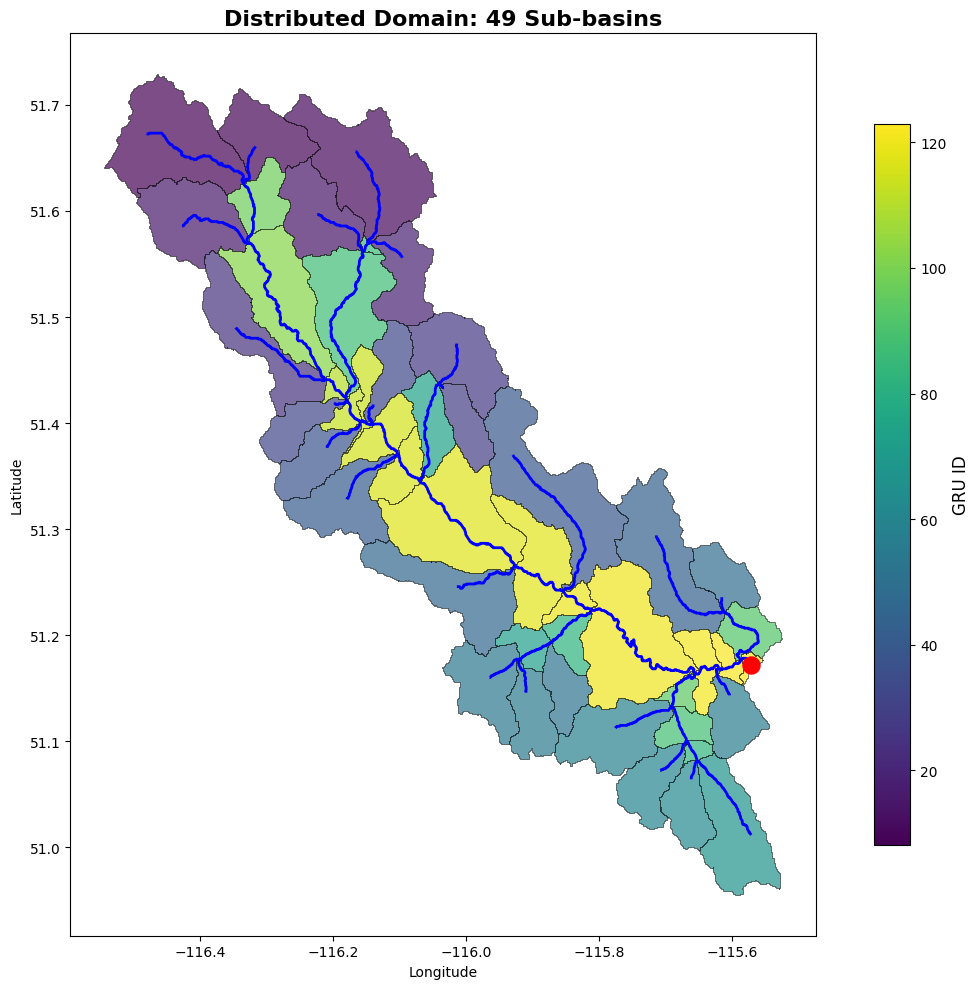

In [6]:
# Visualize the delineated domain with stream network
basin_files = list((project_dir / 'shapefiles' / 'river_basins').glob('*.shp'))
network_files = list((project_dir / 'shapefiles' / 'river_network').glob('*.shp'))
    
if basin_files and network_files:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Load data
    basins = gpd.read_file(basin_files[0])
    rivers = gpd.read_file(network_files[0])
    
    # Plot basins with different colors
    basins.plot(ax=ax, column='GRU_ID', cmap='viridis', 
               alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Plot river network
    rivers.plot(ax=ax, color='blue', linewidth=2)
    
    # Add pour point
    pour_point = gpd.read_file(pour_point_path)
    pour_point.plot(ax=ax, color='red', markersize=150, marker='o', zorder=5)
    
    ax.set_title(f'Distributed Domain: {len(basins)} Sub-basins', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add colorbar for GRU IDs
    sm = plt.cm.ScalarMappable(cmap='viridis', 
                               norm=plt.Normalize(vmin=basins['GRU_ID'].min(), 
                                                 vmax=basins['GRU_ID'].max()))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('GRU ID', fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 8. Geospatial Domain Definition - Discretization

Now we'll create Hydrologic Response Units (HRUs) based on the Grouped Response Units (GRUs) we just created.

In [7]:
# Step 4: Geospatial Domain Definition - Discretization
print("=== Step 4: Geospatial Domain Definition - Discretization ===")

# Discretize domain
print(f"Creating HRUs based on GRUs...")
print(f"Method: {confluence.config['DOMAIN_DISCRETIZATION']}")
print("For this tutorial: 1 GRU = 1 HRU (simplest case)")

hru_path = confluence.managers['domain'].discretize_domain()

# Check the created HRU shapefile
catchment_path = project_dir / 'shapefiles' / 'catchment'
if catchment_path.exists():
    hru_files = list(catchment_path.glob('*.shp'))
    print(f"\n✓ Created HRU shapefiles: {len(hru_files)}")
    
    if hru_files:
        hru_gdf = gpd.read_file(hru_files[0])
        print(f"\nHRU Statistics:")
        print(f"Number of HRUs: {len(hru_gdf)}")
        print(f"Number of GRUs: {hru_gdf['GRU_ID'].nunique()}")
        print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")
        
        # Show HRU distribution
        hru_counts = hru_gdf.groupby('GRU_ID').size()
        print(f"\nHRUs per GRU:")
        for gru_id, count in hru_counts.items():
            print(f"  GRU {gru_id}: {count} HRUs")

=== Step 4: Geospatial Domain Definition - Discretization ===
Creating HRUs based on GRUs...
Method: GRUs
For this tutorial: 1 GRU = 1 HRU (simplest case)
20:03:33 - INFO - Discretizing domain using method: GRUs


2025-05-11 20:03:33,581 - confluence_general - INFO - Discretizing domain using method: GRUs


20:03:33 - INFO - Starting domain discretization using method: grus


2025-05-11 20:03:33,586 - confluence_general - INFO - Starting domain discretization using method: grus


20:03:33 - INFO - Step 1/2: Running discretization method


2025-05-11 20:03:33,588 - confluence_general - INFO - Step 1/2: Running discretization method


20:03:33 - INFO - config domain name Bow_at_Banff_distributed


2025-05-11 20:03:33,589 - confluence_general - INFO - config domain name Bow_at_Banff_distributed


20:03:33 - INFO - Calculating mean elevation for each HRU


2025-05-11 20:03:33,599 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial/discretization_utils.py:208: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages

20:03:33 - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


2025-05-11 20:03:33,893 - confluence_general - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


20:03:34 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/catchment/Bow_at_Banff_distributed_HRUs_as_GRUs.png


2025-05-11 20:03:34,787 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/plots/catchment/Bow_at_Banff_distributed_HRUs_as_GRUs.png


20:03:34 - INFO - Step 2/2: Sorting catchment shape


2025-05-11 20:03:34,789 - confluence_general - INFO - Step 2/2: Sorting catchment shape


20:03:34 - INFO - Sorting catchment shape


2025-05-11 20:03:34,792 - confluence_general - INFO - Sorting catchment shape
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_

20:03:34 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


2025-05-11 20:03:34,830 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment/Bow_at_Banff_distributed_HRUs_GRUs.shp


20:03:34 - INFO - Domain discretization completed in 1.25 seconds


2025-05-11 20:03:34,831 - confluence_general - INFO - Domain discretization completed in 1.25 seconds


20:03:34 - ERROR - Domain discretization failed - no shapefile created


2025-05-11 20:03:34,833 - confluence_general - ERROR - Domain discretization failed - no shapefile created



✓ Created HRU shapefiles: 1

HRU Statistics:
Number of HRUs: 49
Number of GRUs: 49
Total area: 0.00 km²

HRUs per GRU:
  GRU 8: 1 HRUs
  GRU 9: 1 HRUs
  GRU 10: 1 HRUs
  GRU 14: 1 HRUs
  GRU 15: 1 HRUs
  GRU 18: 1 HRUs
  GRU 24: 1 HRUs
  GRU 27: 1 HRUs
  GRU 29: 1 HRUs
  GRU 32: 1 HRUs
  GRU 33: 1 HRUs
  GRU 38: 1 HRUs
  GRU 39: 1 HRUs
  GRU 41: 1 HRUs
  GRU 43: 1 HRUs
  GRU 46: 1 HRUs
  GRU 48: 1 HRUs
  GRU 52: 1 HRUs
  GRU 53: 1 HRUs
  GRU 55: 1 HRUs
  GRU 56: 1 HRUs
  GRU 58: 1 HRUs
  GRU 60: 1 HRUs
  GRU 62: 1 HRUs
  GRU 67: 1 HRUs
  GRU 72: 1 HRUs
  GRU 74: 1 HRUs
  GRU 82: 1 HRUs
  GRU 83: 1 HRUs
  GRU 86: 1 HRUs
  GRU 87: 1 HRUs
  GRU 88: 1 HRUs
  GRU 92: 1 HRUs
  GRU 94: 1 HRUs
  GRU 97: 1 HRUs
  GRU 102: 1 HRUs
  GRU 110: 1 HRUs
  GRU 111: 1 HRUs
  GRU 113: 1 HRUs
  GRU 114: 1 HRUs
  GRU 115: 1 HRUs
  GRU 116: 1 HRUs
  GRU 117: 1 HRUs
  GRU 118: 1 HRUs
  GRU 119: 1 HRUs
  GRU 120: 1 HRUs
  GRU 121: 1 HRUs
  GRU 122: 1 HRUs
  GRU 123: 1 HRUs


/tmp/ipykernel_620638/2701407536.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {hru_gdf.geometry.area.sum() / 1e6:.2f} km²")


## 9. Model Agnostic Data Processing - Observed Data

The observed streamflow data will be the same for both the lumped and distributed models since they use the same pour point.

=== Step 5: Model Agnostic Data Processing - Observed Data ===
Found existing observed data from lumped model. Reusing...
Processing observed streamflow data...
20:03:34 - INFO - Processing observed data


2025-05-11 20:03:34,887 - confluence_general - INFO - Processing observed data


20:03:34 - INFO - Processing WSC streamflow data from HYDAT database


2025-05-11 20:03:34,888 - confluence_general - INFO - Processing WSC streamflow data from HYDAT database


20:03:34 - INFO - Querying data from year 2018 to 2025


2025-05-11 20:03:34,893 - confluence_general - INFO - Querying data from year 2018 to 2025


20:03:34 - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


2025-05-11 20:03:34,895 - confluence_general - INFO - Retrieving discharge data for WSC station 05BB001 from HYDAT database


20:03:34 - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


2025-05-11 20:03:34,896 - confluence_general - INFO - Database path: /work/comphyd_lab/data/geospatial-data/hydat/Hydat.sqlite3


20:03:34 - INFO - Time period: 2018 to 2025


2025-05-11 20:03:34,898 - confluence_general - INFO - Time period: 2018 to 2025


20:03:34 - INFO - Found station 05BB001 in HYDAT database


2025-05-11 20:03:34,918 - confluence_general - INFO - Found station 05BB001 in HYDAT database


20:03:34 - INFO - Station name: BOW RIVER AT BANFF


2025-05-11 20:03:34,919 - confluence_general - INFO - Station name: BOW RIVER AT BANFF


20:03:34 - INFO - Executing SQL query for daily flows...


2025-05-11 20:03:34,921 - confluence_general - INFO - Executing SQL query for daily flows...


20:03:34 - INFO - Retrieved 72 monthly records from HYDAT


2025-05-11 20:03:34,958 - confluence_general - INFO - Retrieved 72 monthly records from HYDAT


20:03:35 - INFO - Processed 2191 daily flow records


2025-05-11 20:03:35,041 - confluence_general - INFO - Processed 2191 daily flow records


20:03:35 - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


2025-05-11 20:03:35,043 - confluence_general - INFO - Date range: 2018-01-01 00:00:00 to 2023-12-31 00:00:00


20:03:35 - INFO - Min flow: 5.809999942779541 m³/s


2025-05-11 20:03:35,045 - confluence_general - INFO - Min flow: 5.809999942779541 m³/s


20:03:35 - INFO - Max flow: 240.0 m³/s


2025-05-11 20:03:35,047 - confluence_general - INFO - Max flow: 240.0 m³/s


20:03:35 - INFO - Mean flow: 38.202441793769964 m³/s


2025-05-11 20:03:35,048 - confluence_general - INFO - Mean flow: 38.202441793769964 m³/s


20:03:35 - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv


2025-05-11 20:03:35,944 - confluence_general - INFO - Processed streamflow data saved to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/observations/streamflow/preprocessed/Bow_at_Banff_distributed_streamflow_processed.csv


20:03:35 - INFO - Total rows in processed data: 52561


2025-05-11 20:03:35,947 - confluence_general - INFO - Total rows in processed data: 52561


20:03:35 - INFO - Number of non-null values: 52561


2025-05-11 20:03:35,949 - confluence_general - INFO - Number of non-null values: 52561


20:03:35 - INFO - Number of null values: 0


2025-05-11 20:03:35,950 - confluence_general - INFO - Number of null values: 0


20:03:35 - INFO - Successfully processed WSC data for station 05BB001


2025-05-11 20:03:35,960 - confluence_general - INFO - Successfully processed WSC data for station 05BB001


20:03:35 - INFO - Observed data processing completed successfully


2025-05-11 20:03:35,962 - confluence_general - INFO - Observed data processing completed successfully


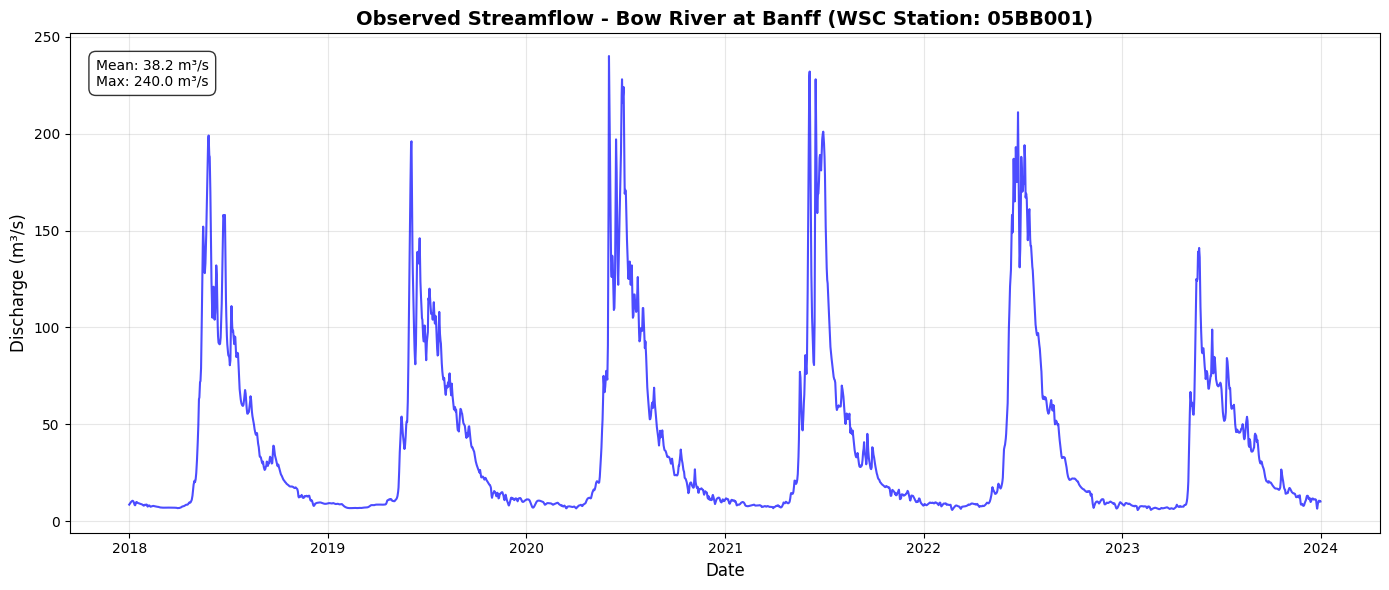

In [8]:
# Step 5: Model Agnostic Data Processing - Observed Data
print("=== Step 5: Model Agnostic Data Processing - Observed Data ===")

# Check if we can reuse data from the lumped model
lumped_obs_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'observations' / 'streamflow' / 'preprocessed'
can_reuse_obs = lumped_obs_path.exists() and list(lumped_obs_path.glob('*.csv'))

if can_reuse_obs:
    print("Found existing observed data from lumped model. Reusing...")
    # We can proceed, but CONFLUENCE will handle the reuse internally

# Process observed data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

# Visualize observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if obs_path.exists():
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
            linewidth=1.5, color='blue', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title(f'Observed Streamflow - Bow River at Banff (WSC Station: {confluence.config["STATION_ID"]})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Mean: {obs_df["discharge_cms"].mean():.1f} m³/s\nMax: {obs_df["discharge_cms"].max():.1f} m³/s', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 10. Model Agnostic Data Processing - Preprocessing

In [ ]:
# Step 7: Model Agnostic Data Processing - Preprocessing
print("=== Step 7: Model Agnostic Data Processing - Preprocessing ===")

# Run model-agnostic preprocessing
print("\nRunning model-agnostic preprocessing...")
confluence.managers['data'].run_model_agnostic_preprocessing()

print("\n✓ Model-agnostic preprocessing completed")

=== Step 7: Model Agnostic Data Processing - Preprocessing ===

Running model-agnostic preprocessing...
20:03:36 - INFO - Starting model-agnostic preprocessing


2025-05-11 20:03:36,359 - confluence_general - INFO - Starting model-agnostic preprocessing


20:03:36 - INFO - Running geospatial statistics


2025-05-11 20:03:36,367 - confluence_general - INFO - Running geospatial statistics


20:03:36 - INFO - Starting geospatial statistics calculation


2025-05-11 20:03:36,370 - confluence_general - INFO - Starting geospatial statistics calculation


20:03:36 - INFO - Calculating soil statistics


2025-05-11 20:03:36,372 - confluence_general - INFO - Calculating soil statistics
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUE

20:03:36 - INFO - Soil statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_soilgrids/default


2025-05-11 20:03:36,608 - confluence_general - INFO - Soil statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_soilgrids/default


20:03:36 - INFO - Calculating land statistics


2025-05-11 20:03:36,610 - confluence_general - INFO - Calculating land statistics
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUE

20:03:36 - INFO - Land statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp


2025-05-11 20:03:36,838 - confluence_general - INFO - Land statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_landclass/catchment_with_landclass.shp


20:03:36 - INFO - Calculating elevation statistics


2025-05-11 20:03:36,840 - confluence_general - INFO - Calculating elevation statistics


20:03:37 - INFO - Updating existing 'elev_mean' column


2025-05-11 20:03:37,070 - confluence_general - INFO - Updating existing 'elev_mean' column
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/dat

20:03:37 - INFO - Elevation statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_dem/default


2025-05-11 20:03:37,104 - confluence_general - INFO - Elevation statistics saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/catchment_intersection/with_dem/default


20:03:37 - INFO - Geospatial statistics completed: 0/3 steps skipped, 3/3 steps executed


2025-05-11 20:03:37,106 - confluence_general - INFO - Geospatial statistics completed: 0/3 steps skipped, 3/3 steps executed


20:03:37 - INFO - Running forcing resampling


2025-05-11 20:03:37,107 - confluence_general - INFO - Running forcing resampling


20:03:37 - INFO - Starting forcing data resampling process


2025-05-11 20:03:37,109 - confluence_general - INFO - Starting forcing data resampling process


20:03:37 - INFO - Creating ERA5 shapefile


2025-05-11 20:03:37,110 - confluence_general - INFO - Creating ERA5 shapefile


20:03:37 - INFO - Creating ERA5 shapefile


2025-05-11 20:03:37,115 - confluence_general - INFO - Creating ERA5 shapefile


20:03:37 - INFO - Using ERA5 file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202109.nc


2025-05-11 20:03:37,124 - confluence_general - INFO - Using ERA5 file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202109.nc


20:03:37 - INFO - ERA5 dimensions: lat=(6,), lon=(7,)


2025-05-11 20:03:37,279 - confluence_general - INFO - ERA5 dimensions: lat=(6,), lon=(7,)


20:03:37 - INFO - ERA5 grid spacings: half_dlat=0.125, half_dlon=0.125


2025-05-11 20:03:37,281 - confluence_general - INFO - ERA5 grid spacings: half_dlat=0.125, half_dlon=0.125


20:03:37 - INFO - Creating grid cell geometries


2025-05-11 20:03:37,283 - confluence_general - INFO - Creating grid cell geometries


20:03:37 - INFO - Multiple latitude values, creating grid


2025-05-11 20:03:37,285 - confluence_general - INFO - Multiple latitude values, creating grid


20:03:37 - INFO - Created 42 grid cell geometries


2025-05-11 20:03:37,291 - confluence_general - INFO - Created 42 grid cell geometries


20:03:37 - INFO - Creating GeoDataFrame


2025-05-11 20:03:37,294 - confluence_general - INFO - Creating GeoDataFrame


20:03:37 - INFO - GeoDataFrame created with 42 rows


2025-05-11 20:03:37,296 - confluence_general - INFO - GeoDataFrame created with 42 rows


20:03:37 - INFO - Calculating zonal statistics with DEM: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif


2025-05-11 20:03:37,298 - confluence_general - INFO - Calculating zonal statistics with DEM: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/attributes/elevation/dem/domain_Bow_at_Banff_distributed_elv.tif


20:03:37 - INFO - Using sample of 42 grid cells for zonal statistics


2025-05-11 20:03:37,300 - confluence_general - INFO - Using sample of 42 grid cells for zonal statistics


20:03:37 - INFO - Processing elevation batch 1/3 (0 to 19)


2025-05-11 20:03:37,302 - confluence_general - INFO - Processing elevation batch 1/3 (0 to 19)


20:03:37 - INFO - Processing elevation batch 2/3 (20 to 39)


/home/darri.eythorsson/code/CONFLUENCE/utils/data/agnosticPreProcessor.py:373: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2338.127669533673' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gdf.loc[idx, 'elev_m'] = item['mean'] if item['mean'] is not None else -9999
2025-05-11 20:03:37,477 - confluence_general - INFO - Processing elevation batch 2/3 (20 to 39)


20:03:37 - INFO - Processing elevation batch 3/3 (40 to 41)


2025-05-11 20:03:37,676 - confluence_general - INFO - Processing elevation batch 3/3 (40 to 41)


20:03:37 - INFO - Elevation calculation complete


2025-05-11 20:03:37,693 - confluence_general - INFO - Elevation calculation complete


20:03:37 - INFO - Saving shapefile to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/forcing/forcing_ERA5.shp


2025-05-11 20:03:37,696 - confluence_general - INFO - Saving shapefile to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/forcing/forcing_ERA5.shp
2025-05-11 20:03:37,718 - pyogrio._io - INFO - Created 42 records


20:03:37 - INFO - ERA5 shapefile saved successfully to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/forcing/forcing_ERA5.shp


2025-05-11 20:03:37,723 - confluence_general - INFO - ERA5 shapefile saved successfully to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/shapefiles/forcing/forcing_ERA5.shp


20:03:37 - INFO - Starting forcing remapping process


2025-05-11 20:03:37,725 - confluence_general - INFO - Starting forcing remapping process


20:03:37 - INFO - Creating weighted forcing files in parallel


2025-05-11 20:03:37,727 - confluence_general - INFO - Creating weighted forcing files in parallel


20:03:37 - INFO - Found 85 forcing files to process


2025-05-11 20:03:37,732 - confluence_general - INFO - Found 85 forcing files to process


20:03:37 - INFO - Using 1 CPUs for parallel processing


2025-05-11 20:03:37,734 - confluence_general - INFO - Using 1 CPUs for parallel processing


20:03:37 - INFO - Found 0 already processed files


2025-05-11 20:03:37,810 - confluence_general - INFO - Found 0 already processed files


20:03:37 - INFO - Found 85 files that need processing


2025-05-11 20:03:37,811 - confluence_general - INFO - Found 85 files that need processing


20:03:37 - INFO - Processing 9 batches of up to 10 files each


2025-05-11 20:03:37,813 - confluence_general - INFO - Processing 9 batches of up to 10 files each


20:03:37 - INFO - Processing batch 1/9 with 10 files


2025-05-11 20:03:37,818 - confluence_general - INFO - Processing batch 1/9 with 10 files


20:03:37 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc


2025-05-11 20:03:37,844 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_ef8e375a_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:03:38,197 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_ef8e375a_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:03:39.239684
It took 1.197466 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc 
Started at date and time 2025-05-11 20:03:39.335984 
Ended at date and time 2025-05-11 20:04:02.457547 
It took 23.121563 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:04:02 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc in 

2025-05-11 20:04:02,687 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_201801.nc in 24.84 seconds


20:04:02 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc


2025-05-11 20:04:02,690 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c5426626_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:04:03,152 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c5426626_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:04:03.820594
It took 0.905277 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc 
Started at date and time 2025-05-11 20:04:03.905313 
Ended at date and time 2025-05-11 20:04:26.642999 
It took 22.737686 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:04:26 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc in 

2025-05-11 20:04:26,706 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202001.nc in 24.02 seconds


20:04:26 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc


2025-05-11 20:04:26,711 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_eb38339b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:04:27,009 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_eb38339b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:04:27.702256
It took 0.81 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc 
Started at date and time 2025-05-11 20:04:27.797842 
Ended at date and time 2025-05-11 20:04:49.927885 
It took 22.130043 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:04:50 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc in 23.3

2025-05-11 20:04:50,027 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202002.nc in 23.32 seconds


20:04:50 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc


2025-05-11 20:04:50,032 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7ad2e661_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:04:50,696 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7ad2e661_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:04:51.508461
It took 0.966403 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc 
Started at date and time 2025-05-11 20:04:51.614365 
Ended at date and time 2025-05-11 20:05:14.288986 
It took 22.674621 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:05:14 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc in 

2025-05-11 20:05:14,341 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202003.nc in 24.31 seconds


20:05:14 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc


2025-05-11 20:05:14,344 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_5dcf3d7b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:05:14,746 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_5dcf3d7b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:05:15.487387
It took 0.895398 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc 
Started at date and time 2025-05-11 20:05:15.579849 
Ended at date and time 2025-05-11 20:05:37.904904 
It took 22.325055 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:05:37 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc in 

2025-05-11 20:05:37,966 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202004.nc in 23.62 seconds


20:05:37 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc


2025-05-11 20:05:37,969 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_d8063784_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:05:38,416 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_d8063784_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:05:39.036509
It took 0.757401 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc 
Started at date and time 2025-05-11 20:05:39.117444 
Ended at date and time 2025-05-11 20:06:01.817921 
It took 22.700477 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:06:02 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc in 

2025-05-11 20:06:02,005 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202005.nc in 24.04 seconds


20:06:02 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc


2025-05-11 20:06:02,008 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_395230d3_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:06:02,381 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_395230d3_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:06:02.995392
It took 0.733875 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc 
Started at date and time 2025-05-11 20:06:03.077548 
Ended at date and time 2025-05-11 20:06:24.974427 
It took 21.896879 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:06:25 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc in 

2025-05-11 20:06:25,043 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202006.nc in 23.03 seconds


20:06:25 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc


2025-05-11 20:06:25,046 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c0a72b94_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:06:25,485 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c0a72b94_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:06:26.267331
It took 0.94383 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc 
Started at date and time 2025-05-11 20:06:26.353225 
Ended at date and time 2025-05-11 20:06:48.883859 
It took 22.530634 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:06:48 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc in 2

2025-05-11 20:06:48,990 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202007.nc in 23.94 seconds


20:06:48 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc


2025-05-11 20:06:48,992 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7cab1fc3_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:06:49,440 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7cab1fc3_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:06:50.284159
It took 1.085771 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc 
Started at date and time 2025-05-11 20:06:50.559748 
Ended at date and time 2025-05-11 20:07:13.151563 
It took 22.591815 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:07:13 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc in 

2025-05-11 20:07:13,290 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202008.nc in 24.30 seconds


20:07:13 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc


2025-05-11 20:07:13,294 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9e2b62e1_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:07:13,830 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9e2b62e1_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:07:14.652682
It took 0.946699 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc 
Started at date and time 2025-05-11 20:07:14.735240 
Ended at date and time 2025-05-11 20:07:36.556520 
It took 21.82128 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:07:36 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc in 2

2025-05-11 20:07:36,655 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202009.nc in 23.36 seconds


20:07:36 - INFO - Batch 1/9 complete: 10/10 successful


2025-05-11 20:07:36,701 - confluence_general - INFO - Batch 1/9 complete: 10/10 successful


20:07:36 - INFO - Processing batch 2/9 with 10 files


2025-05-11 20:07:36,893 - confluence_general - INFO - Processing batch 2/9 with 10 files


20:07:36 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc


2025-05-11 20:07:36,919 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_50f744ac_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:07:37,298 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_50f744ac_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:07:38.339993
It took 1.19782 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc 
Started at date and time 2025-05-11 20:07:38.445347 
Ended at date and time 2025-05-11 20:08:01.084861 
It took 22.639514 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:08:01 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc in 2

2025-05-11 20:08:01,148 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202010.nc in 24.23 seconds


20:08:01 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc


2025-05-11 20:08:01,151 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_798979b9_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:08:01,475 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_798979b9_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:08:02.091648
It took 0.740508 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc 
Started at date and time 2025-05-11 20:08:02.175163 
Ended at date and time 2025-05-11 20:08:24.077719 
It took 21.902556 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:08:24 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc in 

2025-05-11 20:08:24,124 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202011.nc in 22.97 seconds


20:08:24 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc


2025-05-11 20:08:24,126 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_03e9b7a0_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:08:24,480 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_03e9b7a0_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:08:25.085554
It took 0.720296 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc 
Started at date and time 2025-05-11 20:08:25.164239 
Ended at date and time 2025-05-11 20:08:47.706505 
It took 22.542266 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:08:47 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc in 

2025-05-11 20:08:47,757 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202012.nc in 23.63 seconds


20:08:47 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc


2025-05-11 20:08:47,760 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c71f5d0e_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:08:48,101 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c71f5d0e_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:08:48.729545
It took 0.743866 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc 
Started at date and time 2025-05-11 20:08:48.811735 
Ended at date and time 2025-05-11 20:09:11.488127 
It took 22.676392 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:09:11 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc in 

2025-05-11 20:09:11,540 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202101.nc in 23.78 seconds


20:09:11 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc


2025-05-11 20:09:11,543 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4de1e26d_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:09:12,035 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4de1e26d_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:09:12.659162
It took 0.743927 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc 
Started at date and time 2025-05-11 20:09:12.738317 
Ended at date and time 2025-05-11 20:09:33.234024 
It took 20.495707 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:09:33 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc in 

2025-05-11 20:09:33,354 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202102.nc in 21.81 seconds


20:09:33 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc


2025-05-11 20:09:33,356 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a06601e8_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:09:33,696 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a06601e8_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:09:34.287991
It took 0.707294 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc 
Started at date and time 2025-05-11 20:09:34.376936 
Ended at date and time 2025-05-11 20:09:56.990301 
It took 22.613365 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:09:57 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc in 

2025-05-11 20:09:57,043 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202103.nc in 23.69 seconds


20:09:57 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc


2025-05-11 20:09:57,046 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_82aa9050_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:09:57,366 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_82aa9050_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:09:57.974174
It took 0.72524 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc 
Started at date and time 2025-05-11 20:09:58.055193 
Ended at date and time 2025-05-11 20:10:19.992996 
It took 21.937803 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:10:20 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc in 2

2025-05-11 20:10:20,057 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202104.nc in 23.01 seconds


20:10:20 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc


2025-05-11 20:10:20,060 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7439254f_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:10:20,717 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7439254f_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:10:21.339865
It took 0.878549 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc 
Started at date and time 2025-05-11 20:10:21.426153 
Ended at date and time 2025-05-11 20:10:43.901016 
It took 22.474863 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:10:44 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc in 

2025-05-11 20:10:44,105 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202105.nc in 24.05 seconds


20:10:44 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc


2025-05-11 20:10:44,108 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_df3664cc_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:10:44,452 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_df3664cc_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:10:45.102637
It took 0.77094 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc 
Started at date and time 2025-05-11 20:10:45.186484 
Ended at date and time 2025-05-11 20:11:07.055788 
It took 21.869304 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:11:07 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc in 2

2025-05-11 20:11:07,099 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202106.nc in 22.99 seconds


20:11:07 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc


2025-05-11 20:11:07,102 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_60032d5e_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:11:07,425 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_60032d5e_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:11:08.026278
It took 0.717586 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc 
Started at date and time 2025-05-11 20:11:08.117018 
Ended at date and time 2025-05-11 20:11:30.647277 
It took 22.530259 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:11:30 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc in 

2025-05-11 20:11:30,714 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202107.nc in 23.61 seconds


20:11:30 - INFO - Batch 2/9 complete: 10/10 successful


2025-05-11 20:11:30,751 - confluence_general - INFO - Batch 2/9 complete: 10/10 successful


20:11:30 - INFO - Processing batch 3/9 with 10 files


2025-05-11 20:11:30,938 - confluence_general - INFO - Processing batch 3/9 with 10 files


20:11:30 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc


2025-05-11 20:11:30,962 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_53aed0c5_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:11:31,350 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_53aed0c5_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:11:32.642915
It took 1.4574 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc 
Started at date and time 2025-05-11 20:11:32.746828 
Ended at date and time 2025-05-11 20:11:55.456214 
It took 22.709386 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:11:55 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc in 24

2025-05-11 20:11:55,552 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202108.nc in 24.59 seconds


20:11:55 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc


2025-05-11 20:11:55,554 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_effb28ee_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:11:56,468 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_effb28ee_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:11:57.133170
It took 1.259204 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc 
Started at date and time 2025-05-11 20:11:57.220289 
Ended at date and time 2025-05-11 20:12:19.072168 
It took 21.851879 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:12:19 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc in 

2025-05-11 20:12:19,139 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202109.nc in 23.58 seconds


20:12:19 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc


2025-05-11 20:12:19,141 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4d967ffa_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:12:19,646 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4d967ffa_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:12:20.358861
It took 0.950636 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc 
Started at date and time 2025-05-11 20:12:20.456774 
Ended at date and time 2025-05-11 20:12:43.024907 
It took 22.568133 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:12:43 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc in 

2025-05-11 20:12:43,103 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202110.nc in 23.96 seconds


20:12:43 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc


2025-05-11 20:12:43,107 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_73f9a6e0_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:12:43,640 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_73f9a6e0_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:12:44.400565
It took 0.897845 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc 
Started at date and time 2025-05-11 20:12:44.484200 
Ended at date and time 2025-05-11 20:13:06.314518 
It took 21.830318 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:13:06 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc in 

2025-05-11 20:13:06,364 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202111.nc in 23.26 seconds


20:13:06 - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc


2025-05-11 20:13:06,367 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a326c212_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:13:06,754 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a326c212_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:13:07.499819
It took 0.883413 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc 
Started at date and time 2025-05-11 20:13:07.584623 
Ended at date and time 2025-05-11 20:13:30.187904 
It took 22.603281 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:13:30 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc in 

2025-05-11 20:13:30,244 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_distributed_ERA5_merged_202112.nc in 23.88 seconds


20:13:30 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc


2025-05-11 20:13:30,247 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_884467fa_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:13:30,613 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_884467fa_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:13:31.228902
It took 0.750508 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc 
Started at date and time 2025-05-11 20:13:31.308715 
Ended at date and time 2025-05-11 20:13:53.849093 
It took 22.540378 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:13:53 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc in 23.66 

2025-05-11 20:13:53,905 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201801.nc in 23.66 seconds


20:13:53 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc


2025-05-11 20:13:53,909 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_1736e456_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:13:54,230 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_1736e456_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:13:54.854073
It took 0.742859 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc 
Started at date and time 2025-05-11 20:13:54.936209 
Ended at date and time 2025-05-11 20:14:15.341078 
It took 20.404869 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:14:15 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc in 21.51 

2025-05-11 20:14:15,415 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201802.nc in 21.51 seconds


20:14:15 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc


2025-05-11 20:14:15,418 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f773ff0c_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:14:15,772 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f773ff0c_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:14:16.402007
It took 0.75004 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc 
Started at date and time 2025-05-11 20:14:16.500436 
Ended at date and time 2025-05-11 20:14:39.053408 
It took 22.552972 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:14:39 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc in 23.70 s

2025-05-11 20:14:39,117 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201803.nc in 23.70 seconds


20:14:39 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc


2025-05-11 20:14:39,120 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f368e4c6_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:14:39,475 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f368e4c6_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:14:40.124674
It took 0.782978 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc 
Started at date and time 2025-05-11 20:14:40.210250 
Ended at date and time 2025-05-11 20:15:01.937333 
It took 21.727083 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:15:01 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc in 22.87 

2025-05-11 20:15:01,986 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201804.nc in 22.87 seconds


20:15:01 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc


2025-05-11 20:15:01,989 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_727c00e4_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:15:02,338 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_727c00e4_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:15:02.955169
It took 0.730077 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc 
Started at date and time 2025-05-11 20:15:03.035688 
Ended at date and time 2025-05-11 20:15:25.695338 
It took 22.65965 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:15:25 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc in 23.77 s

2025-05-11 20:15:25,758 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201805.nc in 23.77 seconds


20:15:25 - INFO - Batch 3/9 complete: 10/10 successful


2025-05-11 20:15:25,793 - confluence_general - INFO - Batch 3/9 complete: 10/10 successful


20:15:25 - INFO - Processing batch 4/9 with 10 files


2025-05-11 20:15:25,982 - confluence_general - INFO - Processing batch 4/9 with 10 files


20:15:26 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc


2025-05-11 20:15:26,006 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_5eaf7efe_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:15:26,432 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_5eaf7efe_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:15:27.839758
It took 1.602576 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc 
Started at date and time 2025-05-11 20:15:27.932452 
Ended at date and time 2025-05-11 20:15:49.963684 
It took 22.031232 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:15:50 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc in 24.02 

2025-05-11 20:15:50,028 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201806.nc in 24.02 seconds


20:15:50 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc


2025-05-11 20:15:50,031 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_d945cbd0_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:15:50,470 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_d945cbd0_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:15:51.070359
It took 0.728302 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc 
Started at date and time 2025-05-11 20:15:51.151835 
Ended at date and time 2025-05-11 20:16:13.891743 
It took 22.739908 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:16:14 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc in 24.03 

2025-05-11 20:16:14,060 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201807.nc in 24.03 seconds


20:16:14 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc


2025-05-11 20:16:14,064 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_fefc346b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:16:14,530 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_fefc346b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:16:15.205380
It took 0.929997 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc 
Started at date and time 2025-05-11 20:16:15.283803 
Ended at date and time 2025-05-11 20:16:37.984250 
It took 22.700447 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:16:38 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc in 23.99 

2025-05-11 20:16:38,055 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201808.nc in 23.99 seconds


20:16:38 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc


2025-05-11 20:16:38,058 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c6d54f31_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:16:38,843 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c6d54f31_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:16:39.765200
It took 1.519892 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc 
Started at date and time 2025-05-11 20:16:39.847753 
Ended at date and time 2025-05-11 20:17:01.704914 
It took 21.857161 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:17:01 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc in 23.72 

2025-05-11 20:17:01,781 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201809.nc in 23.72 seconds


20:17:01 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc


2025-05-11 20:17:01,783 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_3e65ac4b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:17:02,157 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_3e65ac4b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:17:02.781158
It took 0.779753 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc 
Started at date and time 2025-05-11 20:17:02.863311 
Ended at date and time 2025-05-11 20:17:25.585308 
It took 22.721997 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:17:25 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc in 23.88 

2025-05-11 20:17:25,667 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201810.nc in 23.88 seconds


20:17:25 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc


2025-05-11 20:17:25,669 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_8352de6a_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:17:26,210 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_8352de6a_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:17:26.811791
It took 0.716245 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc 
Started at date and time 2025-05-11 20:17:26.893645 
Ended at date and time 2025-05-11 20:17:48.705332 
It took 21.811687 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:17:48 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc in 23.14 

2025-05-11 20:17:48,807 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201811.nc in 23.14 seconds


20:17:48 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc


2025-05-11 20:17:48,812 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_06e3d760_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:17:49,145 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_06e3d760_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:17:49.801507
It took 0.788246 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc 
Started at date and time 2025-05-11 20:17:49.891995 
Ended at date and time 2025-05-11 20:18:12.482472 
It took 22.590477 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:18:12 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc in 23.72 

2025-05-11 20:18:12,534 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201812.nc in 23.72 seconds


20:18:12 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc


2025-05-11 20:18:12,537 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_74bd5bbc_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:18:12,859 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_74bd5bbc_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:18:13.468760
It took 0.726699 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc 
Started at date and time 2025-05-11 20:18:13.551954 
Ended at date and time 2025-05-11 20:18:36.053328 
It took 22.501374 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:18:36 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc in 23.61 

2025-05-11 20:18:36,151 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201901.nc in 23.61 seconds


20:18:36 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc


2025-05-11 20:18:36,154 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4e7be3eb_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:18:36,470 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4e7be3eb_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:18:37.088469
It took 0.748464 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc 
Started at date and time 2025-05-11 20:18:37.168080 
Ended at date and time 2025-05-11 20:18:57.624131 
It took 20.456051 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:18:57 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc in 21.52 

2025-05-11 20:18:57,675 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201902.nc in 21.52 seconds


20:18:57 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc


2025-05-11 20:18:57,679 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c27e3cc9_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:18:57,986 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c27e3cc9_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:18:58.568579
It took 0.694697 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc 
Started at date and time 2025-05-11 20:18:58.652414 
Ended at date and time 2025-05-11 20:19:21.165390 
It took 22.512976 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:19:21 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc in 23.54 

2025-05-11 20:19:21,217 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201903.nc in 23.54 seconds


20:19:21 - INFO - Batch 4/9 complete: 10/10 successful


2025-05-11 20:19:21,257 - confluence_general - INFO - Batch 4/9 complete: 10/10 successful


20:19:21 - INFO - Processing batch 5/9 with 10 files


2025-05-11 20:19:21,446 - confluence_general - INFO - Processing batch 5/9 with 10 files


20:19:21 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc


2025-05-11 20:19:21,470 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_1b3e72c6_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:19:21,871 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_1b3e72c6_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:19:22.898954
It took 1.174791 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc 
Started at date and time 2025-05-11 20:19:22.995725 
Ended at date and time 2025-05-11 20:19:44.913745 
It took 21.91802 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:19:44 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc in 23.52 s

2025-05-11 20:19:44,989 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201904.nc in 23.52 seconds


20:19:44 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc


2025-05-11 20:19:44,992 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_2564bd08_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:19:45,334 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_2564bd08_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:19:46.256870
It took 1.061646 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc 
Started at date and time 2025-05-11 20:19:46.338750 
Ended at date and time 2025-05-11 20:20:09.166770 
It took 22.82802 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:20:09 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc in 24.26 s

2025-05-11 20:20:09,255 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201905.nc in 24.26 seconds


20:20:09 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc


2025-05-11 20:20:09,258 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_19479cef_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:20:09,642 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_19479cef_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:20:10.972789
It took 1.472047 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc 
Started at date and time 2025-05-11 20:20:11.062544 
Ended at date and time 2025-05-11 20:20:32.977646 
It took 21.915102 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:20:33 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc in 23.78 

2025-05-11 20:20:33,038 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201906.nc in 23.78 seconds


20:20:33 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc


2025-05-11 20:20:33,042 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f058c250_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:20:33,393 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_f058c250_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:20:34.036551
It took 0.778194 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc 
Started at date and time 2025-05-11 20:20:34.122426 
Ended at date and time 2025-05-11 20:20:56.926798 
It took 22.804372 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:20:57 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc in 23.99 

2025-05-11 20:20:57,027 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201907.nc in 23.99 seconds


20:20:57 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc


2025-05-11 20:20:57,029 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7c68e797_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:20:57,781 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_7c68e797_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:20:58.415468
It took 0.758199 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc 
Started at date and time 2025-05-11 20:20:58.509323 
Ended at date and time 2025-05-11 20:21:21.121001 
It took 22.611678 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:21:21 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc in 24.15 

2025-05-11 20:21:21,182 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201908.nc in 24.15 seconds


20:21:21 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc


2025-05-11 20:21:21,186 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a0100cc3_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:21:21,640 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a0100cc3_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:21:22.240788
It took 0.727384 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc 
Started at date and time 2025-05-11 20:21:22.321221 
Ended at date and time 2025-05-11 20:21:44.330215 
It took 22.008994 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:21:44 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc in 23.20 

2025-05-11 20:21:44,385 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201909.nc in 23.20 seconds


20:21:44 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc


2025-05-11 20:21:44,388 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a8a14eb9_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:21:44,723 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a8a14eb9_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:21:45.307675
It took 0.699655 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc 
Started at date and time 2025-05-11 20:21:45.386547 
Ended at date and time 2025-05-11 20:22:08.001232 
It took 22.614685 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:22:08 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc in 23.67 

2025-05-11 20:22:08,061 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201910.nc in 23.67 seconds


20:22:08 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc


2025-05-11 20:22:08,064 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4c07aead_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:22:08,383 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4c07aead_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:22:09.014129
It took 0.749335 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc 
Started at date and time 2025-05-11 20:22:09.096497 
Ended at date and time 2025-05-11 20:22:30.929407 
It took 21.83291 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:22:30 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc in 22.93 s

2025-05-11 20:22:30,992 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201911.nc in 22.93 seconds


20:22:30 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc


2025-05-11 20:22:30,994 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_53097cc3_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:22:31,338 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_53097cc3_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:22:32.004008
It took 0.797893 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc 
Started at date and time 2025-05-11 20:22:32.084176 
Ended at date and time 2025-05-11 20:22:54.800017 
It took 22.715841 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:22:54 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc in 23.86 

2025-05-11 20:22:54,851 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_201912.nc in 23.86 seconds


20:22:54 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc


2025-05-11 20:22:54,853 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_2dc0fcbe_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:22:55,153 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_2dc0fcbe_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:22:55.761735
It took 0.727626 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc 
Started at date and time 2025-05-11 20:22:55.841667 
Ended at date and time 2025-05-11 20:23:18.392725 
It took 22.551058 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:23:18 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc in 23.60 

2025-05-11 20:23:18,454 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202001.nc in 23.60 seconds


20:23:18 - INFO - Batch 5/9 complete: 10/10 successful


2025-05-11 20:23:18,487 - confluence_general - INFO - Batch 5/9 complete: 10/10 successful


20:23:18 - INFO - Processing batch 6/9 with 10 files


2025-05-11 20:23:18,678 - confluence_general - INFO - Processing batch 6/9 with 10 files


20:23:18 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc


2025-05-11 20:23:18,704 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9c9cf5c1_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:23:19,108 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9c9cf5c1_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:23:20.113859
It took 1.157123 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc 
Started at date and time 2025-05-11 20:23:20.209400 
Ended at date and time 2025-05-11 20:23:41.510418 
It took 21.301018 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:23:41 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc in 22.86 

2025-05-11 20:23:41,565 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202002.nc in 22.86 seconds


20:23:41 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc


2025-05-11 20:23:41,568 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4a5df02e_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:23:41,955 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_4a5df02e_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:23:42.591435
It took 0.755191 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc 
Started at date and time 2025-05-11 20:23:42.688678 
Ended at date and time 2025-05-11 20:24:05.414138 
It took 22.72546 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:24:05 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc in 23.92 s

2025-05-11 20:24:05,486 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202003.nc in 23.92 seconds


20:24:05 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc


2025-05-11 20:24:05,488 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_8db0ff17_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:24:05,850 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_8db0ff17_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:24:06.473136
It took 0.746505 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc 
Started at date and time 2025-05-11 20:24:06.554881 
Ended at date and time 2025-05-11 20:24:28.416888 
It took 21.862007 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:24:28 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc in 22.99 

2025-05-11 20:24:28,479 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202004.nc in 22.99 seconds


20:24:28 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc


2025-05-11 20:24:28,482 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9f1c5a2b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:24:28,826 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_9f1c5a2b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:24:29.486585
It took 0.782411 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc 
Started at date and time 2025-05-11 20:24:29.569916 
Ended at date and time 2025-05-11 20:24:52.194920 
It took 22.625004 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:24:52 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc in 23.76 

2025-05-11 20:24:52,240 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202005.nc in 23.76 seconds


20:24:52 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc


2025-05-11 20:24:52,243 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_59e2d438_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:24:52,792 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_59e2d438_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:24:53.395699
It took 0.713983 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc 
Started at date and time 2025-05-11 20:24:53.481562 
Ended at date and time 2025-05-11 20:25:15.388412 
It took 21.90685 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:25:15 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc in 23.20 s

2025-05-11 20:25:15,438 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202006.nc in 23.20 seconds


20:25:15 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc


2025-05-11 20:25:15,440 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_772de0d0_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:25:15,988 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_772de0d0_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:25:16.599816
It took 0.726082 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc 
Started at date and time 2025-05-11 20:25:16.679477 
Ended at date and time 2025-05-11 20:25:39.373781 
It took 22.694304 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:25:39 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc in 24.00 

2025-05-11 20:25:39,436 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202007.nc in 24.00 seconds


20:25:39 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc


2025-05-11 20:25:39,439 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_fde83ccb_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:25:39,764 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_fde83ccb_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:25:40.368365
It took 0.722155 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc 
Started at date and time 2025-05-11 20:25:40.455719 
Ended at date and time 2025-05-11 20:26:03.056099 
It took 22.60038 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:26:03 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc in 23.67 s

2025-05-11 20:26:03,108 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202008.nc in 23.67 seconds


20:26:03 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc


2025-05-11 20:26:03,111 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_aada760f_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:26:03,453 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_aada760f_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:26:04.520542
It took 1.196888 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc 
Started at date and time 2025-05-11 20:26:04.607952 
Ended at date and time 2025-05-11 20:26:26.175371 
It took 21.567419 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:26:26 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc in 23.20 

2025-05-11 20:26:26,307 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202009.nc in 23.20 seconds


20:26:26 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc


2025-05-11 20:26:26,309 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a3029d05_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:26:26,684 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_a3029d05_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:26:27.313759
It took 0.760492 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc 
Started at date and time 2025-05-11 20:26:27.410247 
Ended at date and time 2025-05-11 20:26:49.638443 
It took 22.228196 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:26:49 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc in 23.39 

2025-05-11 20:26:49,701 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202010.nc in 23.39 seconds


20:26:49 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc


2025-05-11 20:26:49,703 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_6db8f3e0_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:26:50,093 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_6db8f3e0_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:26:50.784442
It took 0.819287 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4
Remapping /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/raw_data/domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/basin_averaged_data/Bow_at_Banff_distributed_ERA5_remapped_domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc 
Started at date and time 2025-05-11 20:26:50.863202 
Ended at date and time 2025-05-11 20:27:12.418795 
It took 21.555593 seconds to finish the remapping of variable(s) 
---------------------
---------------------
20:27:12 - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc in 22.77 

2025-05-11 20:27:12,469 - confluence_general - INFO - Worker 0: Successfully processed domain_Bow_at_Banff_elevation_ERA5_merged_202011.nc in 22.77 seconds


20:27:12 - INFO - Batch 6/9 complete: 10/10 successful


2025-05-11 20:27:12,507 - confluence_general - INFO - Batch 6/9 complete: 10/10 successful


20:27:12 - INFO - Processing batch 7/9 with 10 files


2025-05-11 20:27:12,703 - confluence_general - INFO - Processing batch 7/9 with 10 files


20:27:12 - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202012.nc


2025-05-11 20:27:12,726 - confluence_general - INFO - Worker 0: Processing file domain_Bow_at_Banff_elevation_ERA5_merged_202012.nc


EASYMORE version 2.0.0 is initiated.
EASYMORE is given multiple variables for remapping but only one format and fill value. EASYMORE repeats the format and fill value for all the variables in output files
EASYMORE will remap variable  airpres  from source file to variable  airpres  in remapped netCDF file
EASYMORE will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped netCDF file
EASYMORE will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped netCDF file
EASYMORE will remap variable  pptrate  from source file to variable  pptrate  in remapped netCDF file
EASYMORE will remap variable  airtemp  from source file to variable  airtemp  in remapped netCDF file
EASYMORE will remap variable  spechum  from source file to variable  spechum  in remapped netCDF file
EASYMORE will remap variable  windspd  from source file to variable  windspd  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dim

/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

EASYMORE saved target shapefile for EASYMORE claculation as:
/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c5b22e4b_0/Bow_at_Banff_distributed_ERA5_target_shapefile.shp
EASYMORE detects case 1 - regular lat/lon


2025-05-11 20:27:13,110 - pyogrio._io - INFO - Created 42 records


/work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_distributed/forcing/temp_easymore_c5b22e4b_0/Bow_at_Banff_distributed_ERA5_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 107654506.629659668 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 115962979.782231942 of field GRU_area of feature 2 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: Runtim

Ended at date and time 2025-05-11 20:27:14.157292
It took 1.213818 seconds to finish creating of the remapping file
---------------------------
Running within a SLURM job.
SLURM environment variables found: ['SLURM_JOBID', 'SLURM_JOB_NAME', 'SLURM_NODELIST']
------REMAPPING------
netcdf output file will be compressed at level 4


## 11. Model-Specific Processing - Preprocessing

Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case), set up for a distributed configuration.

In [ ]:
# Step 8: Model Specific Processing and Initialization
print("=== Step 8: Model Specific Processing and Initialization ===")

# Preprocess models
print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
print(f"Note: For distributed mode with {confluence.config['HYDROLOGICAL_MODEL']}, this includes generating:")
print(f"  - Model parameter files for each GRU")
print(f"  - Routing configuration for river network")

confluence.managers['model'].preprocess_models()

print("\n✓ Model-specific preprocessing completed")

## 13. Run the Distributed Model

Now we execute the SUMMA model in distributed mode with routing.

In [ ]:
# Step 9: Run the Distributed Model
print("=== Step 9: Run the Distributed Model ===")

# Run the model
print(f"Running distributed {confluence.config['HYDROLOGICAL_MODEL']} model...")
print(f"Number of GRUs: (check from previous output)")
print("Note: This will take longer than the lumped model due to multiple units.")

confluence.managers['model'].run_models()

print("\n✓ Model execution completed")

## 14. Distributed Model Benchmarking

Let's run benchmarking to evaluate the performance of our distributed model.

In [ ]:
# Step 10: Distributed Model Benchmarking
print("=== Step 10: Distributed Model Benchmarking ===")

# Run benchmarking
print("\nRunning benchmarking analysis...")
benchmark_results = confluence.managers['analysis'].run_benchmarking()

print("\n✓ Benchmarking completed")

## 15. Visualize Distributed Model Results

In [ ]:
# Postprocess results and visualize
print("Post-processing model results...")
confluence.managers['model'].postprocess_results()

# Load and plot simulation results
sim_path = project_dir / 'simulations' / confluence.config['EXPERIMENT_ID'] / 'mizuRoute'
sim_files = list(sim_path.glob('*.nc'))

if sim_files:
    # Load simulation data
    sim_data = xr.open_dataset(sim_files[0])
    
    # Load observation data
    obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    # Find the segment ID for the outlet
    if 'reachID' in sim_data.dims:
        outlet_idx = sim_data.reachID.values == confluence.config['SIM_REACH_ID']
        if any(outlet_idx):
            # Extract simulated flow at outlet
            sim_flow = sim_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            sim_df = pd.DataFrame({'datetime': sim_flow.index, 'flow': sim_flow.values})
            
            # Plot comparison
            fig, ax = plt.subplots(figsize=(14, 6))
            
            # Plot observed flow
            ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
                    color='blue', linewidth=1.5, label='Observed')
            
            # Plot simulated flow
            ax.plot(sim_df['datetime'], sim_df['flow'], 
                    color='red', linewidth=1.5, alpha=0.7, label='Simulated (Distributed)')
            
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Discharge (m³/s)', fontsize=12)
            ax.set_title('Distributed Model Results - Bow River at Banff', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
    else:
        print("Could not find reachID dimension in simulation output")
else:
    print("No simulation results found. Check model execution.")

## 16. Compare Lumped vs Distributed Results (Optional)

If you've completed the lumped model tutorial, we can compare results between the two approaches.

In [ ]:
# Try to load lumped model results for comparison
lumped_sim_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'simulations' / 'run_1' / 'mizuRoute'
lumped_sim_files = list(lumped_sim_path.glob('*.nc')) if lumped_sim_path.exists() else []

if lumped_sim_files:
    print("Found lumped model results. Creating comparison plot...")
    
    # Load lumped simulation data
    lumped_data = xr.open_dataset(lumped_sim_files[0])
    
    # Load distributed simulation data
    dist_sim_path = project_dir / 'simulations' / confluence.config['EXPERIMENT_ID'] / 'mizuRoute'
    dist_sim_files = list(dist_sim_path.glob('*.nc'))
    
    if dist_sim_files:
        dist_data = xr.open_dataset(dist_sim_files[0])
        
        # Load observation data
        obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
        obs_df = pd.read_csv(obs_path)
        obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
        
        # Extract flows
        # Find the segment ID for the outlet
        if 'reachID' in dist_data.dims and 'reachID' in lumped_data.dims:
            # Extract distributed flow
            dist_flow = dist_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            dist_df = pd.DataFrame({'datetime': dist_flow.index, 'flow': dist_flow.values})
            
            # Extract lumped flow
            lumped_flow = lumped_data.IRFroutedRunoff.sel(reachID=confluence.config['SIM_REACH_ID']).to_pandas()
            lumped_df = pd.DataFrame({'datetime': lumped_flow.index, 'flow': lumped_flow.values})
            
            # Plot comparison
            fig, ax = plt.subplots(figsize=(14, 6))
            
            # Plot observed flow
            ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
                    color='black', linewidth=1.5, label='Observed')
            
            # Plot lumped flow
            ax.plot(lumped_df['datetime'], lumped_df['flow'], 
                    color='blue', linewidth=1.5, alpha=0.7, label='Lumped Model')
            
            # Plot distributed flow
            ax.plot(dist_df['datetime'], dist_df['flow'], 
                    color='red', linewidth=1.5, alpha=0.7, label='Distributed Model')
            
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Discharge (m³/s)', fontsize=12)
            ax.set_title('Lumped vs Distributed Model Comparison - Bow River at Banff', 
                        fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
            
    else:
        print("Distributed simulation results not found. Run the distributed model first.")
else:
    print("Lumped model results not found. Complete Tutorial 2 first for comparison.")

## 17. Optional Steps - Optimization and Analysis

These steps are optional and could be run to further explore the distributed model.

In [ ]:
# Step 11: Optional Steps (Optimization and Analysis)
print("=== Step 11: Optional Steps ===")

# Check if optimization is enabled
if confluence.config.get('RUN_ITERATIVE_OPTIMISATION', False):
    print("Running model calibration...")
    optimization_results = confluence.managers['optimization'].calibrate_model()
else:
    print("Model calibration skipped (RUN_ITERATIVE_OPTIMISATION = False)")

# Check if emulation is enabled
if confluence.config.get('RUN_LARGE_SAMPLE_EMULATION', False) or confluence.config.get('RUN_RANDOM_FOREST_EMULATION', False):
    print("Running parameter emulation...")
    emulation_results = confluence.managers['optimization'].run_emulation()
else:
    print("Parameter emulation skipped")

# Check if decision analysis is enabled
if confluence.config.get('RUN_DECISION_ANALYSIS', False):
    print("Running decision analysis...")
    decision_results = confluence.managers['analysis'].run_decision_analysis()
else:
    print("Decision analysis skipped")

# Check if sensitivity analysis is enabled
if confluence.config.get('RUN_SENSITIVITY_ANALYSIS', False):
    print("Running sensitivity analysis...")
    sensitivity_results = confluence.managers['analysis'].run_sensitivity_analysis()
else:
    print("Sensitivity analysis skipped")

## 18. Compare Domain Structures: Lumped vs Distributed

Let's create a visual comparison of the domain structures.

In [ ]:
# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Lumped model visualization (if exists)
lumped_basin_path = CONFLUENCE_DATA_DIR / 'domain_Bow_at_Banff_lumped' / 'shapefiles' / 'river_basins'
if lumped_basin_path.exists():
    lumped_files = list(lumped_basin_path.glob('*.shp'))
    if lumped_files:
        lumped_basin = gpd.read_file(lumped_files[0])
        lumped_basin.plot(ax=ax1, color='lightblue', edgecolor='navy', linewidth=2)
        ax1.set_title('Lumped Model\n(1 Unit)', fontsize=14, fontweight='bold')
        ax1.axis('off')

# Distributed model visualization
dist_basin_path = project_dir / 'shapefiles' / 'river_basins'
dist_network_path = project_dir / 'shapefiles' / 'river_network'

if dist_basin_path.exists() and dist_network_path.exists():
    dist_basin_files = list(dist_basin_path.glob('*.shp'))
    dist_network_files = list(dist_network_path.glob('*.shp'))
    
    if dist_basin_files and dist_network_files:
        basins = gpd.read_file(dist_basin_files[0])
        network = gpd.read_file(dist_network_files[0])
        
        basins.plot(ax=ax2, column='GRU_ID', cmap='viridis', 
                   edgecolor='black', linewidth=0.5, alpha=0.7)
        network.plot(ax=ax2, color='blue', linewidth=2)
        ax2.set_title(f'Distributed Model\n({len(basins)} GRUs)', fontsize=14, fontweight='bold')
        ax2.axis('off')

plt.suptitle('Lumped vs Distributed Domain Structure', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 19. Summary and Key Differences

### What we accomplished:
1. Created a distributed model with multiple GRUs
2. Used stream network delineation
3. Maintained 1:1 relationship between GRUs and HRUs
4. Ran the same model (SUMMA) in distributed mode
5. Reused data from the lumped model where possible

### Key differences from lumped model:
- **Multiple spatial units**: Several GRUs instead of one
- **River routing**: mizuRoute connects the GRUs
- **More detailed representation**: Captures spatial variability
- **Longer computation time**: More units to simulate

### Next steps:
1. Compare performance metrics between lumped and distributed
2. Experiment with different stream thresholds
3. Try different discretization methods (elevation bands, land cover)
4. Calibrate parameters for individual GRUs

In [ ]:
# Print final summary
print("=== Distributed Workflow Complete ===\n")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"Method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
print(f"Stream Threshold: {confluence.config['STREAM_THRESHOLD']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"\nKey outputs:")
print(f"  - Basin shapefile: {project_dir}/shapefiles/river_basins/")
print(f"  - River network: {project_dir}/shapefiles/river_network/")
print(f"  - Model results: {project_dir}/simulations/{confluence.config['EXPERIMENT_ID']}/")
print(f"  - Comparison plots: {project_dir}/plots/results/")

# Get workflow status
status = confluence.workflow_orchestrator.get_workflow_status()
print(f"\nWorkflow Status:")
print(f"Total steps: {status['total_steps']}")
print(f"Completed steps: {status['completed_steps']}")
print(f"Pending steps: {status['pending_steps']}")

## 20. Alternative - Run Complete Workflow

Instead of running the workflow step by step, you could use CONFLUENCE's built-in workflow orchestration to run the entire process at once.

In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()